# Loading and Evaluating Multiple Models

This notebooks serves as a guide on how to load multiple models that were saved in the way described in [workbook.ipynb](workbook.ipynb). We will also look at how to evaluate them using an independent test dataset.

In [1]:
import json
import os
from pathlib import Path
from urllib.request import urlretrieve

import awkward as ak
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

from models import from_config

# Load models

In [2]:
save_path = Path("models_fulltrain")

In [3]:
!ls -la $save_path

total 77
drwxr-xr-x.  9 arvanitis.vyron campususer  9 Aug  2 10:02 .
drwxr-xr-x. 12 arvanitis.vyron campususer 32 Aug  2 09:57 ..
drwxr-xr-x.  2 arvanitis.vyron campususer  6 Aug  2 09:08 deepset_cartesian
drwxr-xr-x.  2 arvanitis.vyron campususer  6 Aug  2 09:12 deepset_combined_cartesian
drwxr-xr-x.  2 arvanitis.vyron campususer  6 Aug  2 09:24 deepset_combined_wgcn_cartesian
drwxr-xr-x.  2 arvanitis.vyron campususer  6 Aug  2 09:58 deepset_combined_wgcn_normalized_cartesian
drwxr-xr-x.  2 arvanitis.vyron campususer  6 Aug  2 09:17 deepset_gcn_cartesian
drwxr-xr-x.  2 arvanitis.vyron campususer  6 Aug  2 10:14 optimal_model_cylindrical
drwxr-xr-x.  2 arvanitis.vyron campususer  6 Aug  2 09:48 transformer_cartesian


In [ ]:
# manually select models to evaluate
configs = [
 'deepset_cartesian',
 'deepset_combined_cartesian',
 'deepset_gcn_cartesian',
 'deepset_combined_wgcn_cartesian',
 'transformer_cartesian',
 'deepset_combined_wgcn_normalized_cartesian',
 'optimal_model_cylindrical'
]

# alternative: all models in `save_path`
# configs = [path.name for path in save_path.iterdir()]
configs

['deepset_cartesian',
 'deepset_combined_cartesian',
 'deepset_gcn_cartesian',
 'deepset_combined_wgcn_cartesian',
 'transformer_cartesian',
 'deepset_combined_wgcn_normalized_cartesian',
 'optimal_model_cylindrical']

In [5]:
models = {}
for tag in configs:
    model_path = save_path / tag
    with open(model_path / "config.json") as f:
        config = json.load(f)
    model = from_config(config)
    state = torch.load(model_path / "state.pt")
    model.load_state_dict(state)

    clean_tag = tag.split("/")[-1]  # keep only last part if there's a "/"
    models[clean_tag] = model

/scratch-local/slurm-job-tmp-8493223/ipykernel_37243/2277742703.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path / "state.pt")
/software/opt

In [6]:
models

{'deepset_cartesian': DeepSet(
   (deep_set_layer): DeepSetLayer(
     (per_item_mlp): Sequential(
       (0): Linear(in_features=8, out_features=32, bias=True)
       (1): ReLU()
     )
     (global_mlp): Sequential(
       (0): Linear(in_features=32, out_features=32, bias=True)
       (1): ReLU()
     )
   )
   (output_layer): OutputLayer(
     (output_layer): Sequential(
       (0): Linear(in_features=32, out_features=1, bias=True)
     )
   )
 ),
 'deepset_combined_cartesian': CombinedModel(
   (embedding_layer): Embedding(185, 8)
   (deep_set_layer): DeepSetLayer(
     (per_item_mlp): Sequential(
       (0): Linear(in_features=16, out_features=32, bias=True)
       (1): ReLU()
     )
     (global_mlp): Sequential(
       (0): Linear(in_features=32, out_features=32, bias=True)
       (1): ReLU()
     )
   )
   (output_layer): OutputLayer(
     (output_layer): Sequential(
       (0): Linear(in_features=32, out_features=1, bias=True)
     )
   )
 ),
 'deepset_gcn_cartesian': DeepSet_

# Load test data

In [7]:
from utils import GraphDataset, load_data, map_np, collate_fn, preprocess, get_adj, loss_fn, accuracy_fn

In [8]:
filename = "smartbkg_dataset_4k_testing.parquet"
url = "https://zenodo.org/records/15303496/files/smartbkg_dataset_4k_testing.parquet?download=1"
# url = ... # url for testdata will be provided on second lab day

In [9]:
if not os.path.exists(filename):
    urlretrieve(url, filename)

In [10]:

feature_columns_map = {
    "cartesian": ["prodTime", "x", "y", "z", "energy", "px", "py", "pz"],
    "cylindrical": ["r", "z", "p_xy", "pz", "prodTime", "energy"]
}

df, labels = load_data(filename, row_groups=[0,1,2,3])

In [11]:
with open("pdg_mapping.json") as f:
    pdg_mapping = dict(json.load(f))
df["pdg_mapped"] = map_np(df.pdg, pdg_mapping, fallback=len(pdg_mapping) + 1)

In [12]:
data_cartesian = preprocess(df, pdg_mapping=pdg_mapping, feature_columns=feature_columns_map["cartesian"], coordinates="cartesian")
data_cylindrical = preprocess(df, pdg_mapping=pdg_mapping, feature_columns=feature_columns_map["cylindrical"], coordinates="cylindrical")

In [14]:
data_cartesian["adj"] = [get_adj(index, mother) for index, mother in zip(data_cartesian["index"], data_cartesian["mother"])]
data_cylindrical["adj"] = [get_adj(index, mother) for index, mother in zip(data_cylindrical["index"], data_cylindrical["mother"])]

In [15]:
dl_cartesian = torch.utils.data.DataLoader(
    GraphDataset(feat=data_cartesian["features"], pdg=data_cartesian["pdg_mapped"], adj=data_cartesian["adj"], y=labels),
    batch_size=256,
    collate_fn=collate_fn
)

dl_cylindrical = torch.utils.data.DataLoader(
    GraphDataset(feat=data_cylindrical["features"], pdg=data_cylindrical["pdg_mapped"], adj=data_cylindrical["adj"], y=labels),
    batch_size=256,
    collate_fn=collate_fn
)


# Evaluation

If we let some test data run through one of our trained models, each event in that dataset will be mapped to a number between 0 and 1. This is due to the sigmoid activation function used for every last layer. The output value can be interpreted as the confidence the models has in a particular event passing the skimming. In order to decide which events get thrown away prior to the detector simulation, a threshold needs to be selected. That way every event which generated an output less than the threshold gets thrown away and the others are kept. To each threshold, there is a corresponding pair of true and false positive rates (FPR, TPR). We can plot them against each other, leading to a *reciever operating characteristic* (ROC) curve. Looking at the graphic below, this curve can be used to evaluate the model's performance, which can be quantified by calculating the area under the ROC curve (auc).  

![](figures/Roc_curve.png)

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, accuracy_score, auc, roc_auc_score

The following function will run our model once through the DataLoader to produce pairs of model outputs (`logits`) and targets (`y`):

In [17]:
def evaluate(model, dl):
    model.eval()
    out_y = []
    out_logits = []
    for x, y, mask in tqdm(dl):
        out_y.append(y)
        with torch.no_grad():
            logits = model(x, mask=mask)
        out_logits.append(logits.squeeze())

    return torch.cat(out_y), torch.cat(out_logits)

In [18]:
for name, model in models.items():
    print(name)
    print(model)
    

deepset_cartesian
DeepSet(
  (deep_set_layer): DeepSetLayer(
    (per_item_mlp): Sequential(
      (0): Linear(in_features=8, out_features=32, bias=True)
      (1): ReLU()
    )
    (global_mlp): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
    )
  )
  (output_layer): OutputLayer(
    (output_layer): Sequential(
      (0): Linear(in_features=32, out_features=1, bias=True)
    )
  )
)
deepset_combined_cartesian
CombinedModel(
  (embedding_layer): Embedding(185, 8)
  (deep_set_layer): DeepSetLayer(
    (per_item_mlp): Sequential(
      (0): Linear(in_features=16, out_features=32, bias=True)
      (1): ReLU()
    )
    (global_mlp): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
    )
  )
  (output_layer): OutputLayer(
    (output_layer): Sequential(
      (0): Linear(in_features=32, out_features=1, bias=True)
    )
  )
)
deepset_gcn_cartesian
DeepSet_wGCN(
  (gcn_layer): GCN(
    (linear): Linear(

In [20]:
for name, model in models.items():
    if "cylindrical" in name:
        print("Evaluating", name)
        scores[name] = evaluate(model, dl_cylindrical)
    else:
        print("Evaluating", name)
        scores[name] = evaluate(model, dl_cartesian)


Evaluating deepset_cartesian


100%|██████████| 1563/1563 [00:08<00:00, 179.63it/s]


Evaluating deepset_combined_cartesian


100%|██████████| 1563/1563 [00:08<00:00, 192.13it/s]


Evaluating deepset_gcn_cartesian


100%|██████████| 1563/1563 [00:11<00:00, 131.98it/s]


Evaluating deepset_combined_wgcn_cartesian


100%|██████████| 1563/1563 [00:13<00:00, 113.62it/s]


Evaluating transformer_cartesian


100%|██████████| 1563/1563 [00:29<00:00, 52.74it/s]


Evaluating deepset_combined_wgcn_normalized_cartesian


100%|██████████| 1563/1563 [00:14<00:00, 108.15it/s]


Evaluating optimal_model_cylindrical


100%|██████████| 1563/1563 [00:19<00:00, 80.48it/s]


In [21]:
# Folder to save results
save_path = Path("Evaluation_results")
save_path.mkdir(exist_ok=True)


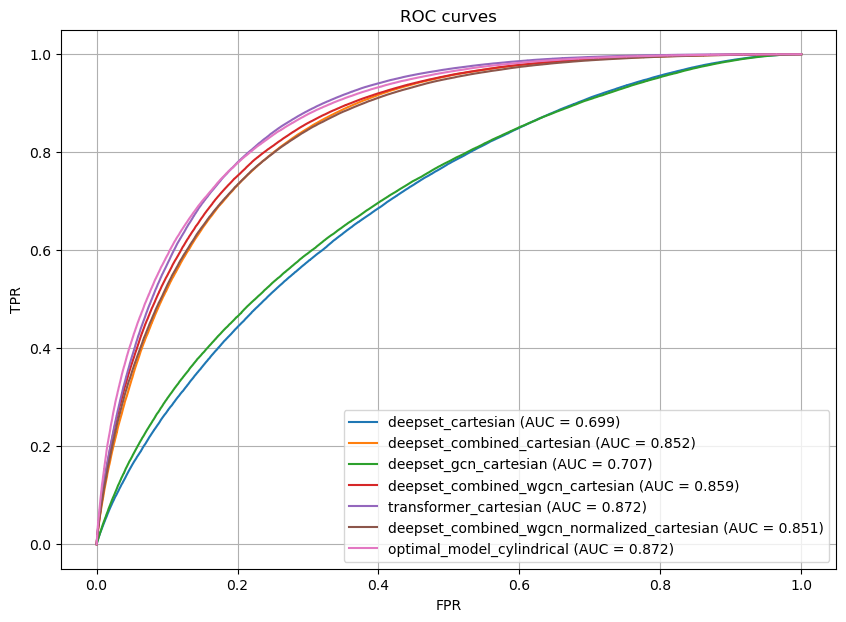

In [30]:
plt.figure(figsize=(10, 7))  

for name, (y_true, y_logits) in scores.items():
    y_score = y_logits.sigmoid()
    fpr, tpr, thr = roc_curve(y_true.numpy(), y_score.numpy())
    auc_score = auc(fpr, tpr)
    label = f"{name} (AUC = {auc_score:.3f})"
    plt.plot(fpr, tpr, label=label)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curves")
plt.legend()
plt.grid()
plt.savefig(save_path / "ROC_curves.png")


In [23]:
summary = []
for (name, model), (y_true, y_logits) in zip(models.items(), scores.values()):
    y_score = y_logits.sigmoid()
    fpr, tpr, thr = roc_curve(y_true.numpy(), y_score.numpy())
    loss = loss_fn(y_logits, y_true)
    accuracy = accuracy_fn(y_logits, y_true)
    summary.append(
        {
            "Model": name,
            "Loss": loss.item(),
            "Accuracy": accuracy.item(),
            "AUC": auc(fpr, tpr),
        }
    )

In [24]:
summary

[{'Model': 'deepset_cartesian',
  'Loss': 0.6326069831848145,
  'Accuracy': 0.6363949775695801,
  'AUC': 0.699286279175},
 {'Model': 'deepset_combined_cartesian',
  'Loss': 0.4759317636489868,
  'Accuracy': 0.7752825021743774,
  'AUC': 0.8516842379624999},
 {'Model': 'deepset_gcn_cartesian',
  'Loss': 0.6245923042297363,
  'Accuracy': 0.6466224789619446,
  'AUC': 0.7070236984124999},
 {'Model': 'deepset_combined_wgcn_cartesian',
  'Loss': 0.46728789806365967,
  'Accuracy': 0.778612494468689,
  'AUC': 0.8592068257625001},
 {'Model': 'transformer_cartesian',
  'Loss': 0.44072839617729187,
  'Accuracy': 0.7949525117874146,
  'AUC': 0.8718769747249999},
 {'Model': 'deepset_combined_wgcn_normalized_cartesian',
  'Loss': 0.47700557112693787,
  'Accuracy': 0.7733075022697449,
  'AUC': 0.8509875691500001},
 {'Model': 'optimal_model_cylindrical',
  'Loss': 0.4444965720176697,
  'Accuracy': 0.7917425036430359,
  'AUC': 0.8723799592624999}]

In [25]:
df_summary = pd.DataFrame(summary).set_index("Model")
df_summary.to_csv(save_path / "summary.csv")


# Speedup estimation

How do we finally choose a threshold? We want our model to deliver the highest possible speedup to our simulation chain. With certain assumptions (see [labday.md](labday.md)), a formula can be derived that only depends on FPR, TPR. This will be your job. With that you can plot against the thresholds a speedup curve and find its maximum as well as the corresponding optimal threshold.

In [26]:
def speedup(fpr, tpr):
    r = 0.05
    speed_up = (101 * tpr) / (1 + (tpr*r+fpr*(1-r))*100) 
    return speed_up

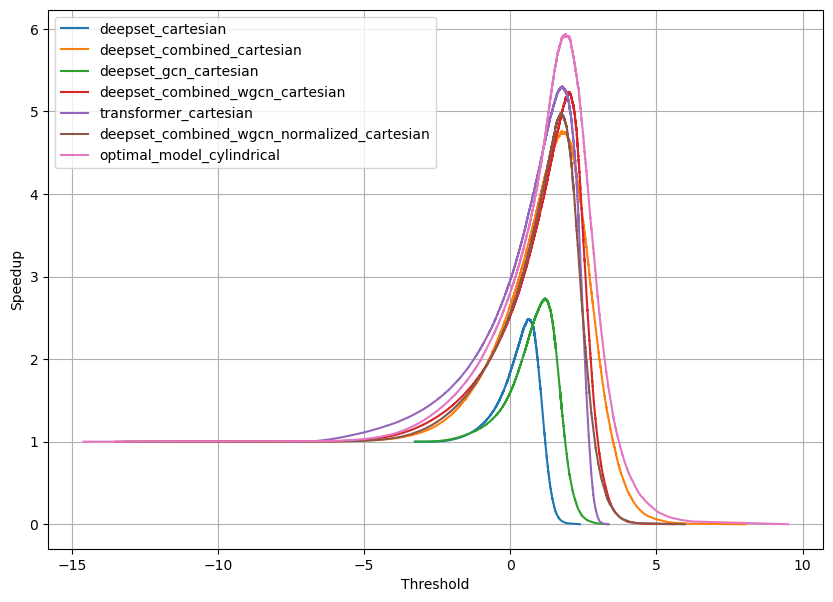

In [31]:
plt.figure(figsize=(10, 7))  

for i, (model_name, (labels, score)) in enumerate(scores.items()):
    fpr, tpr, thr = roc_curve(labels, score)
    s = speedup(fpr, tpr)
    s_max = max(s)
    thr_max = thr[np.argmax(s)]
    summary[i]["Max. Speedup"] = s_max
    summary[i]["Best Threshold"] = thr_max
    plt.plot(thr[1:], s[1:], label=model_name)
plt.xlabel("Threshold")
plt.ylabel("Speedup")
plt.legend()
plt.grid()
plt.savefig(save_path / "Speedupt.png")


In [32]:
df_summary = pd.DataFrame(summary).set_index("Model")
df_summary.to_csv(save_path / "summary.csv")
print(df_summary)


                                                Loss  Accuracy       AUC  \
Model                                                                      
deepset_cartesian                           0.632607  0.636395  0.699286   
deepset_combined_cartesian                  0.475932  0.775283  0.851684   
deepset_gcn_cartesian                       0.624592  0.646622  0.707024   
deepset_combined_wgcn_cartesian             0.467288  0.778612  0.859207   
transformer_cartesian                       0.440728  0.794953  0.871877   
deepset_combined_wgcn_normalized_cartesian  0.477006  0.773308  0.850988   
optimal_model_cylindrical                   0.444497  0.791743  0.872380   

                                            Max. Speedup  Best Threshold  
Model                                                                     
deepset_cartesian                               2.484777        0.618467  
deepset_combined_cartesian                      4.757561        1.756557  
deepset_gcn_car